In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

results = pd.read_csv("out/results/results.csv")
results

,trotterization,coloring,n_terms,depth,time,hid
0,suzuki_trotter,none,229,90,11.365,binaryoptimization/maxcut/biqmac/rudy-hams/9-p...
1,suzuki_trotter,saturation,456,59,297.433,binaryoptimization/maxcut/biqmac/rudy-hams/2-w...
2,suzuki_trotter,saturation,3,3,1.024,binaryoptimization/maxcut/biqmac/rudy-hams/9-g...
3,suzuki_trotter,degree,17767,393,939.238,binaryoptimization/maxcut/biqmac/ising-hams/6-...
4,suzuki_trotter,none,231,105,9.872,binaryoptimization/maxcut/biqmac/ising-hams/6-...
...,...,...,...,...,...,...
2350495,suzuki_trotter,none,14,11,0.949,binaryoptimization/maxcut/biqmac/rudy-hams/3-p...
2350496,suzuki_trotter,degree,108,17,9.138,binaryoptimization/maxcut/biqmac/rudy-hams/10-...
2350497,suzuki_trotter,saturation,46656,149,338.077,discreteoptimization/tsp/TSP_Ncity-36/tsp_rand...
2350498,suzuki_trotter,degree,90,19,18.131,binaryoptimization/maxcut/biqmac/rudy-hams/1-p...


In [3]:
df = results.groupby(["hid", "trotterization", "coloring"]).mean()
df = df.reset_index(level=2)

baseline = df[df["coloring"] == "none"].drop(["coloring", "n_terms"], axis=1)

df["depth_saved_pc"] = (baseline["depth"] - df["depth"]) * 100 / baseline["depth"]
df["time_extra_pc"] = (df["time"] - baseline["time"]) * 100 / baseline["time"]
# df = df[df["coloring"] != "none"]
df = df.reset_index()

df["problem_group"] = df["hid"].map(lambda hid: "/".join(hid.split("/")[:-2]))

df = df.astype({"n_terms": int})
df

,hid,trotterization,coloring,n_terms,depth,time,depth_saved_pc,time_extra_pc,problem_group
0,binaryoptimization/maxcut/biqmac/ising-hams/1-...,suzuki_trotter,degree,45,21.3,4.5616,50.233645,178.316046,binaryoptimization/maxcut/biqmac
1,binaryoptimization/maxcut/biqmac/ising-hams/1-...,suzuki_trotter,none,45,42.8,1.6390,0.000000,0.000000,binaryoptimization/maxcut/biqmac
2,binaryoptimization/maxcut/biqmac/ising-hams/1-...,suzuki_trotter,saturation,45,18.9,4.9674,55.841121,203.075046,binaryoptimization/maxcut/biqmac
3,binaryoptimization/maxcut/biqmac/ising-hams/1-...,suzuki_trotter,degree,4852,209.3,563.2221,68.728522,25.299800,binaryoptimization/maxcut/biqmac
4,binaryoptimization/maxcut/biqmac/ising-hams/1-...,suzuki_trotter,none,4852,669.3,449.4996,0.000000,0.000000,binaryoptimization/maxcut/biqmac
...,...,...,...,...,...,...,...,...,...
235045,discreteoptimization/tsp/TSP_penalties/tsppena...,suzuki_trotter,none,8235,45788.4,289.2138,0.000000,0.000000,discreteoptimization/tsp
235046,discreteoptimization/tsp/TSP_penalties/tsppena...,suzuki_trotter,saturation,8235,20400.6,686.1166,55.445921,137.235084,discreteoptimization/tsp
235047,discreteoptimization/tsp/TSP_penalties/tsppena...,suzuki_trotter,degree,405,24.3,26.3751,45.146727,159.766187,discreteoptimization/tsp
235048,discreteoptimization/tsp/TSP_penalties/tsppena...,suzuki_trotter,none,405,44.3,10.1534,0.000000,0.000000,discreteoptimization/tsp


[(0.0, 100.0)]

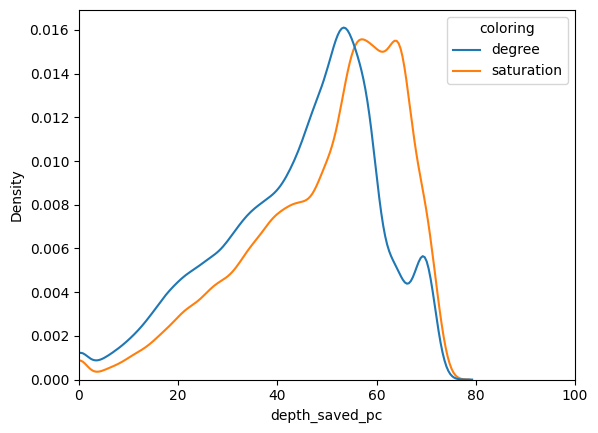

In [23]:
import seaborn as sns

_df = df[(df["trotterization"] == "suzuki_trotter") & (df["coloring"] != "none")]
ax = sns.kdeplot(data=_df, x="depth_saved_pc", hue="coloring", clip=(0, 100))
ax.set(xlim=(0, 100))

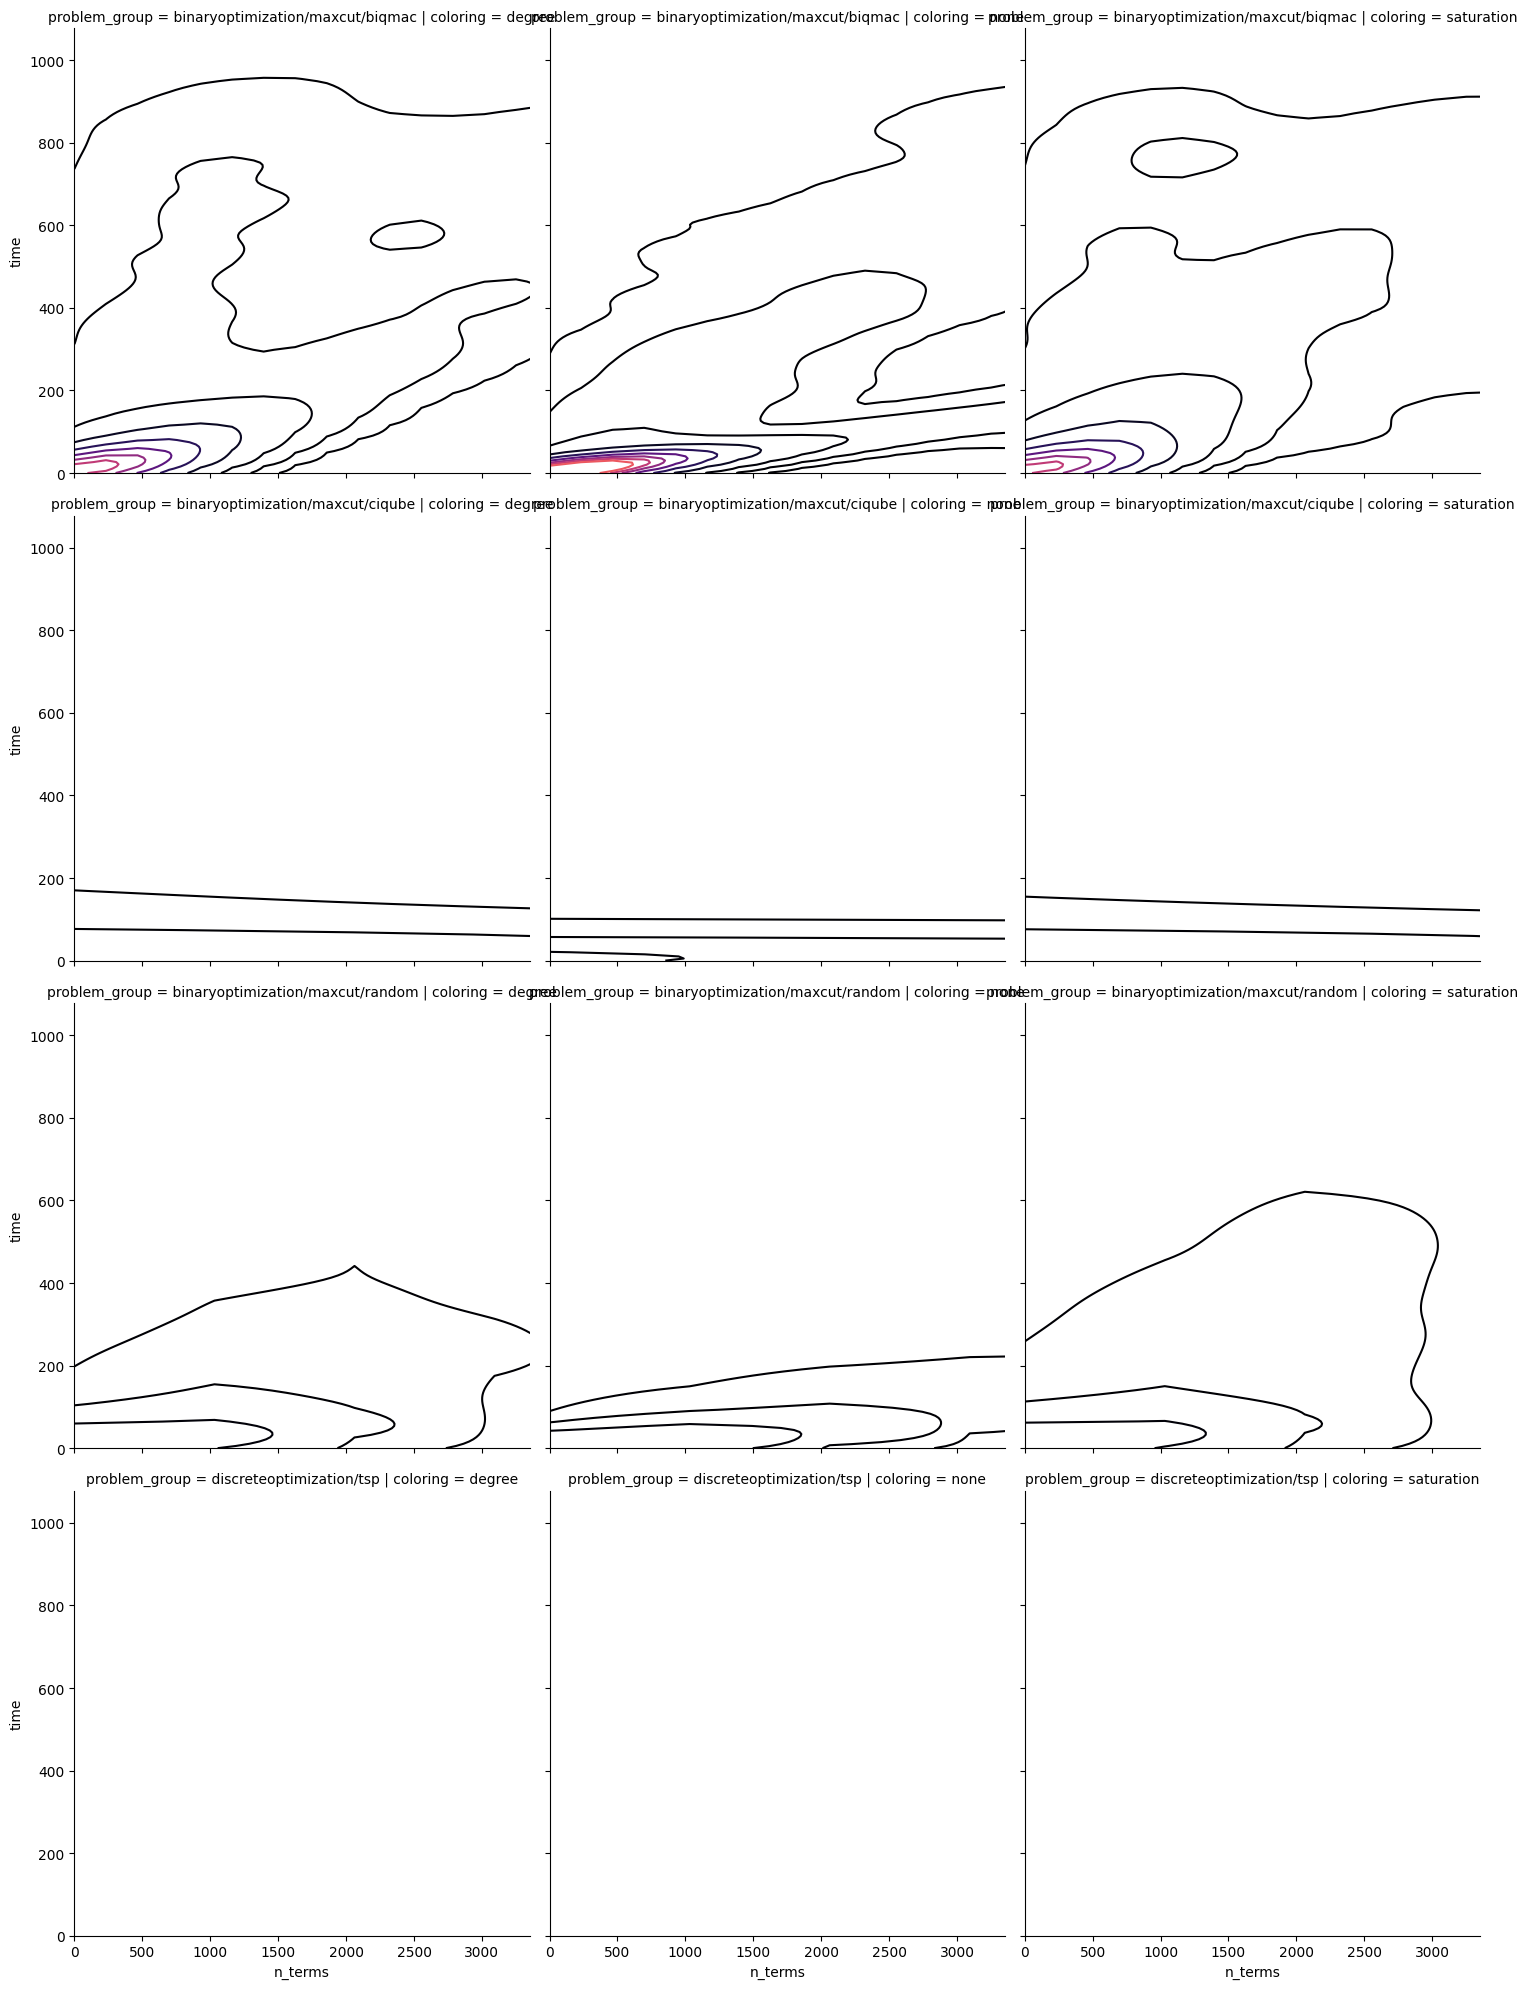

In [46]:
import seaborn as sns

_df = df[(df["trotterization"] == "suzuki_trotter")]
ax = sns.displot(
    data=_df,
    x="n_terms",
    y="time",
    col="coloring",
    row="problem_group",
    kind="kde",
    clip=((0, None), (0, None)),
    cmap="magma",
)

QUANTILE = 0.9
x_max = _df["n_terms"].quantile(QUANTILE) * 1.1
y_max = _df["time"].max() * 1.1
ax.set(xlim=(0, x_max), ylim=(0, y_max))

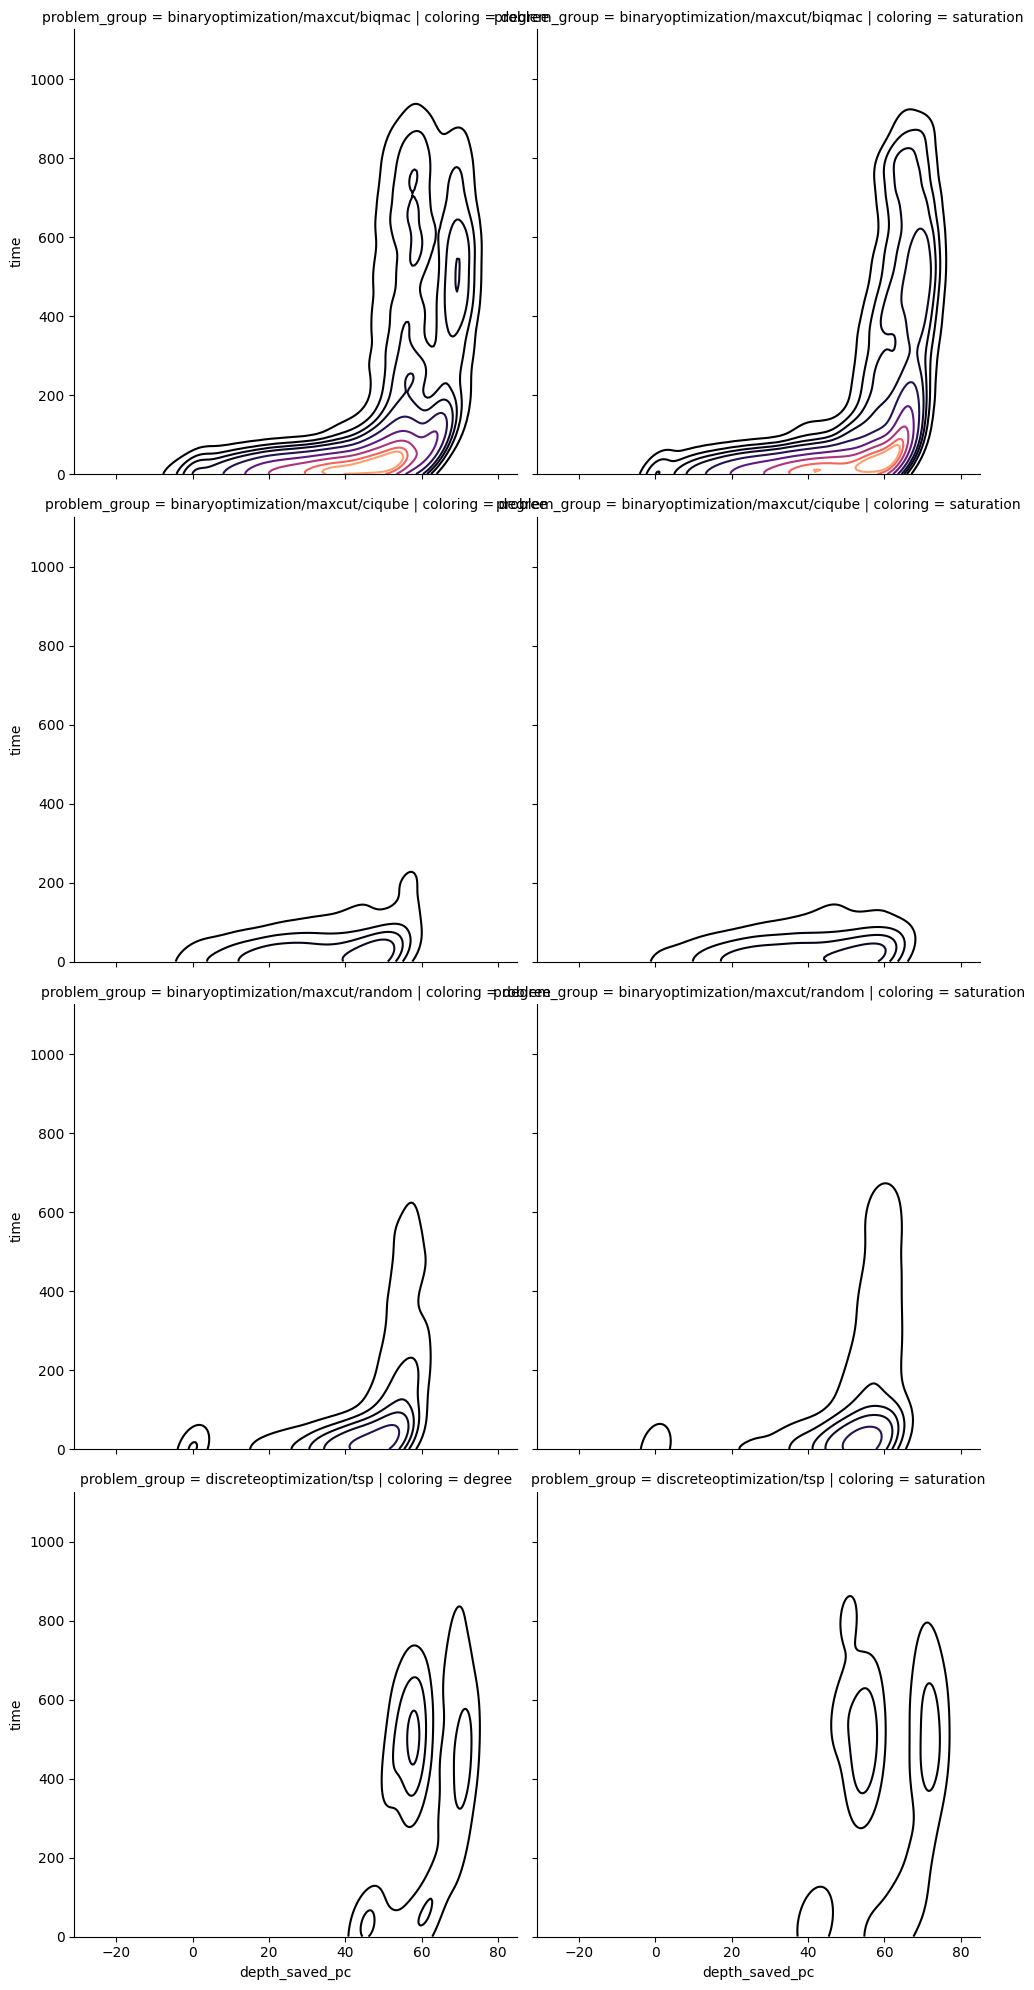

In [42]:
import seaborn as sns

_df = df[df["coloring"] != "none"]
ax = sns.displot(
    data=_df,
    x="depth_saved_pc",
    y="time",
    col="coloring",
    row="problem_group",
    kind="kde",
    cmap="magma",
    clip=((None, None), (0, None)),
)

# QUANTILE = 0.99
# x_min = _df["depth_saved_pc"].quantile(1 - QUANTILE)
# x_max = _df["depth_saved_pc"].quantile(QUANTILE)
# y_min = _df["time"].quantile(1 - QUANTILE)
# y_max = _df["time"].quantile(QUANTILE)
# x_min *= 1.1 if x_min <= 0 else 0.9
# x_max *= 0.9 if x_max <= 0 else 1.1
# y_min *= 1.1 if x_min <= 0 else 0.9
# y_max *= 0.9 if y_max <= 0 else 1.1
# ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

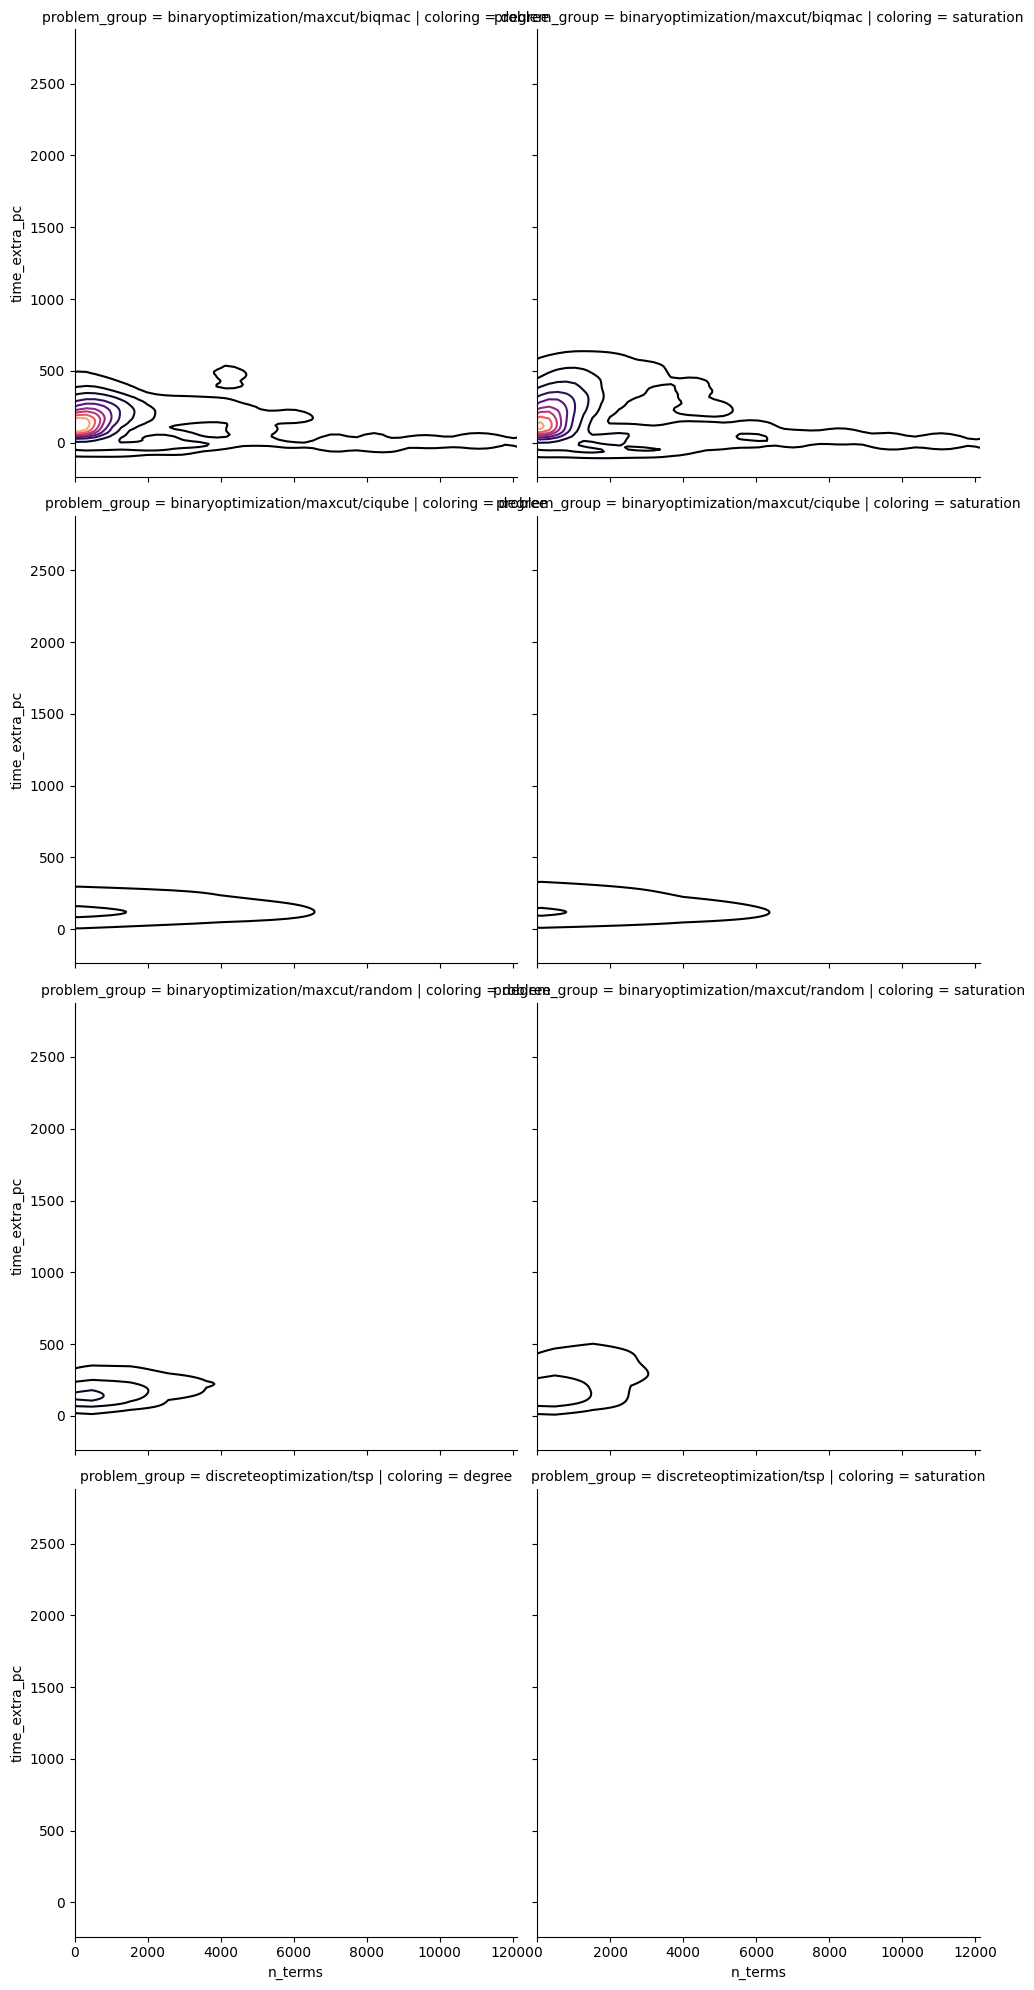

In [47]:
import seaborn as sns

_df = df[df["coloring"] != "none"]
ax = sns.displot(
    data=_df,
    x="n_terms",
    y="time_extra_pc",
    col="coloring",
    row="problem_group",
    kind="kde",
    cmap="magma",
)

QUANTILE = 0.95
x_min = 0
x_max = _df["n_terms"].quantile(QUANTILE)
x_max *= 0.9 if x_max <= 0 else 1.1
ax.set(xlim=(x_min, x_max))

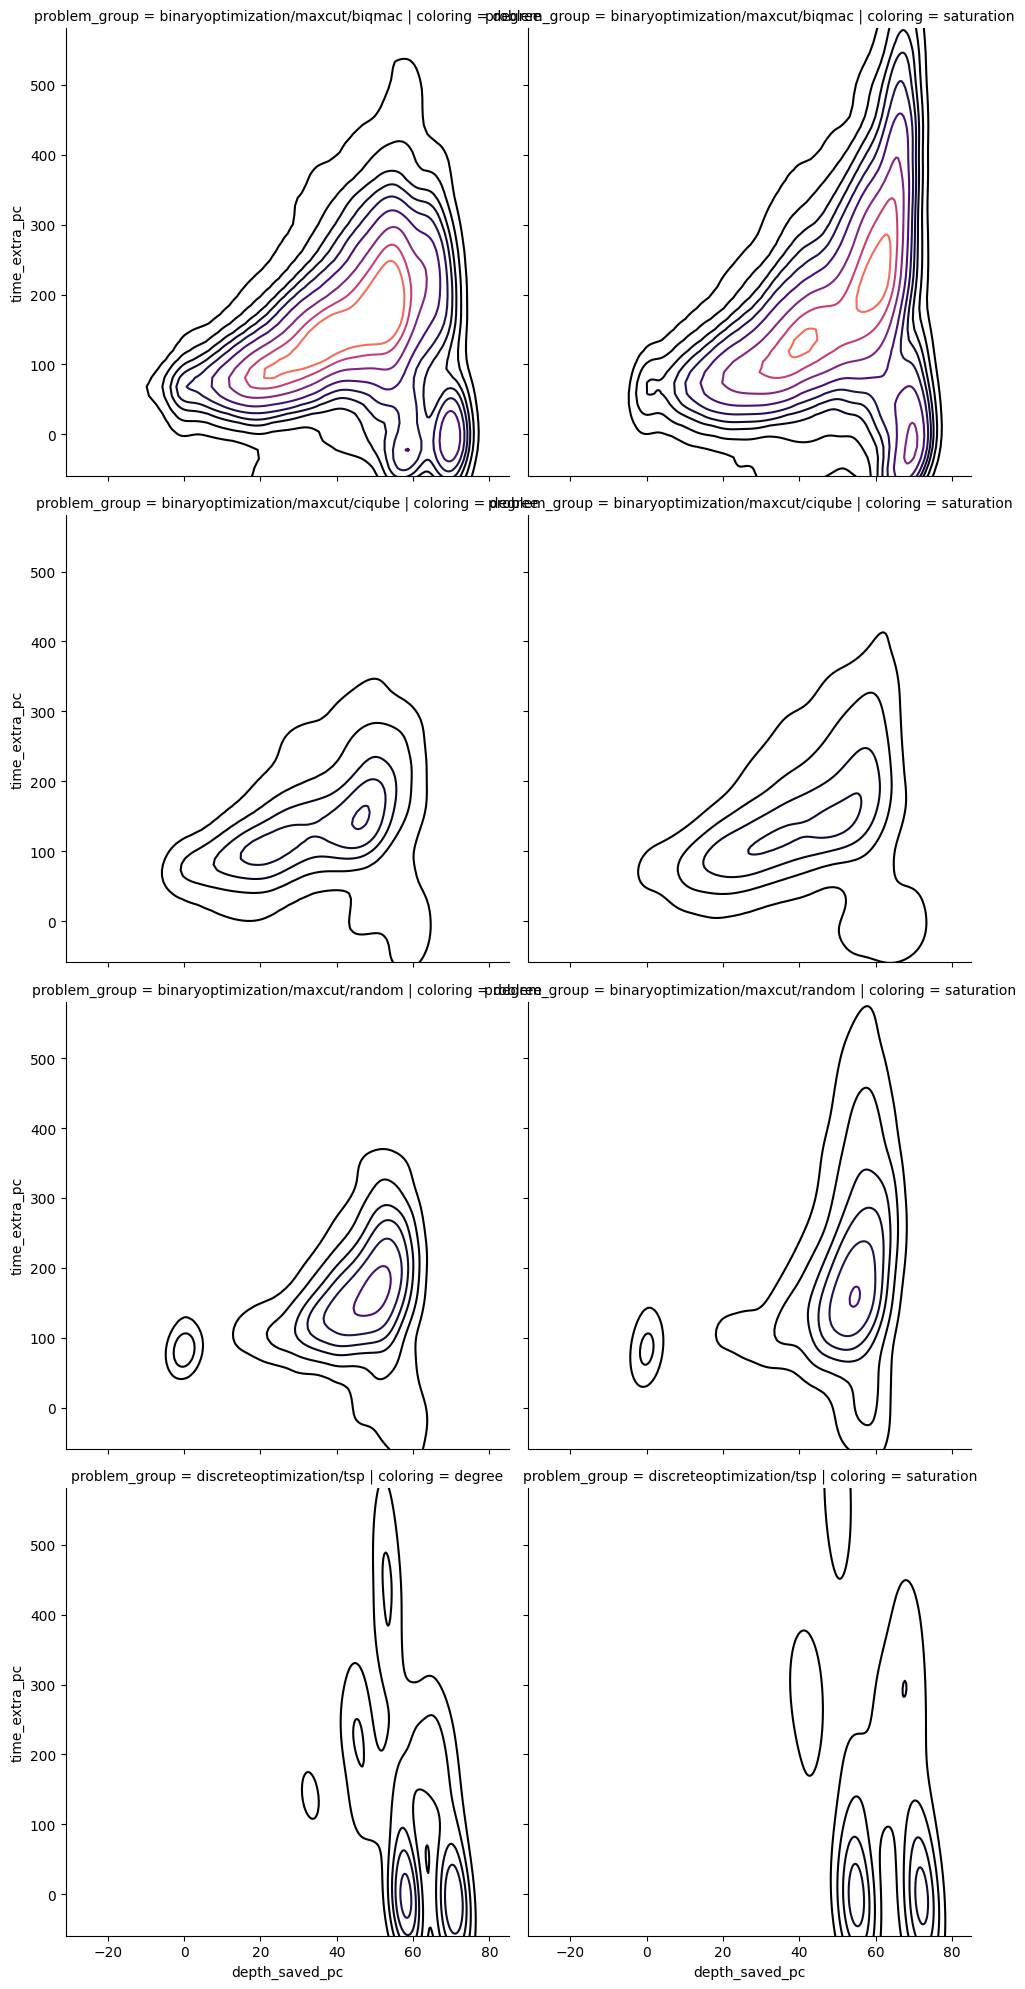

In [48]:
import seaborn as sns

_df = df[df["coloring"] != "none"]
ax = sns.displot(
    data=_df,
    x="depth_saved_pc",
    y="time_extra_pc",
    col="coloring",
    row="problem_group",
    kind="kde",
    cmap="magma",
)

QUANTILE = 0.99
y_min = _df["time_extra_pc"].quantile(1 - QUANTILE)
y_max = _df["time_extra_pc"].quantile(QUANTILE)
y_min *= 1.1 if x_min <= 0 else 0.9
y_max *= 0.9 if y_max <= 0 else 1.1
ax.set(ylim=(y_min, y_max))